In [1]:
import pymc as pm

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import os
# Replace 'path_to_graphviz_bin' with the actual path to your Graphviz 'bin' directory.
graphviz_bin_path = '/opt/conda/envs/pymc-test/bin/'
# Append the Graphviz 'bin' directory to the PATH.
os.environ["PATH"] += os.pathsep + graphviz_bin_path

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import numpyro

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.10.4


/opt/conda/envs/pymc-test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18])
J = len(y)

In [5]:
model1 = pm.Model()

In [6]:
with model1 as pooled:
    # Latent pooled effect size
    mu = pm.Normal("mu", 0, sigma=1e6)

    obs = pm.Normal("obs", mu, sigma=sigma, observed=y)

In [7]:
g = pm.model_to_graphviz(model1)

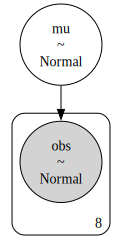

In [8]:
display(g)

In [26]:
with model1:
    trace_p = pm.sample(2000, random_seed=42,nuts_sampler="blackjax",idata_kwargs={"log_likelihood": True})

Compiling...
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/pymc/sampling/jax.py:459: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(
Compilation time = 0:00:00.388417
Sampling...
Sampling time = 0:00:03.378508
Transforming variables...
Transformation time = 0:00:00.051821
Computing Log Likelihood...
Log Likelihood time = 0:00:00.125123


In [27]:
trace_p

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

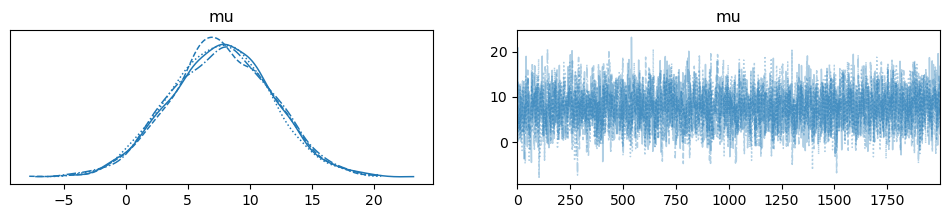

In [28]:
az.plot_trace(trace_p)

In [14]:
model2= pm.Model()

In [15]:
with model2 as hierarchical:
    eta = pm.Normal("eta", 0, 1, shape=J)
    # Hierarchical mean and SD
    mu = pm.Normal("mu", 0, sigma=10)
    tau = pm.HalfNormal("tau", 10)

    # Non-centered parameterization of random effect
    theta = pm.Deterministic("theta", mu + tau * eta)

    obs = pm.Normal("obs", theta, sigma=sigma, observed=y)

In [16]:
g2 = pm.model_to_graphviz(model2)

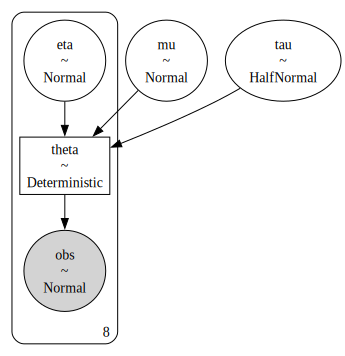

In [17]:
display(g2)

In [21]:
with model2:
    trace_h = pm.sample(2000, random_seed=42,nuts_sampler="blackjax",idata_kwargs={"log_likelihood": True})

Compiling...
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/pymc/sampling/jax.py:459: UserWarning: BlackJax currently only display progress bar correctly under `chain_method == 'vectorized'`. Setting `progressbar=False`.
  warnings.warn(
Compilation time = 0:00:00.726779
Sampling...
Sampling time = 0:00:05.285386
Transforming variables...
Transformation time = 0:00:00.113575
Computing Log Likelihood...
Log Likelihood time = 0:00:00.399614


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

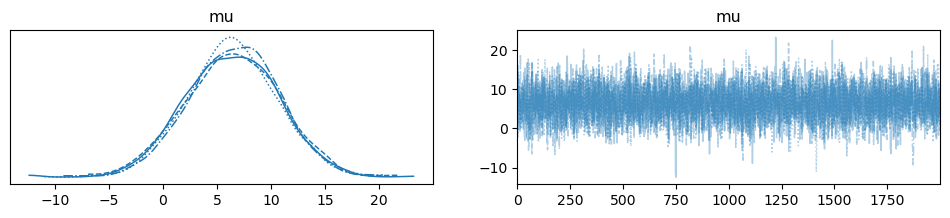

In [22]:
az.plot_trace(trace_h, var_names="mu")

<Axes: >

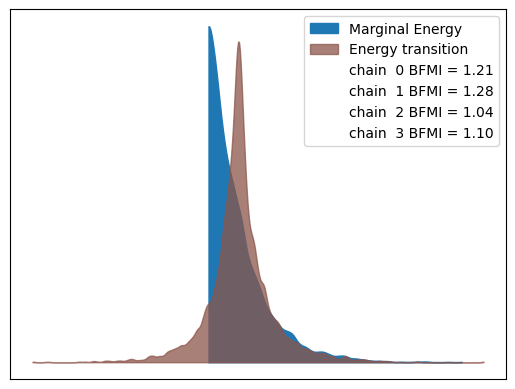

In [29]:
az.plot_energy(trace_p)

<Axes: >

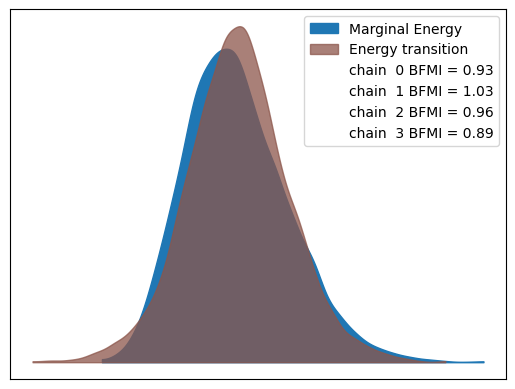

In [25]:
az.plot_energy(trace_h)

In [30]:
df_comp_loo = az.compare({"model1": trace_p, "model2": trace_h})
df_comp_loo

/opt/conda/envs/pymc-test/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/arviz/stats/stats.py:309: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model1,0,-30.575189,0.684704,0.000000,1.000000e+00,1.109690,0.00000,False,log
model2,1,-30.855335,1.200057,0.280145,4.440892e-16,1.089359,0.20381,False,log


/opt/conda/envs/pymc-test/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

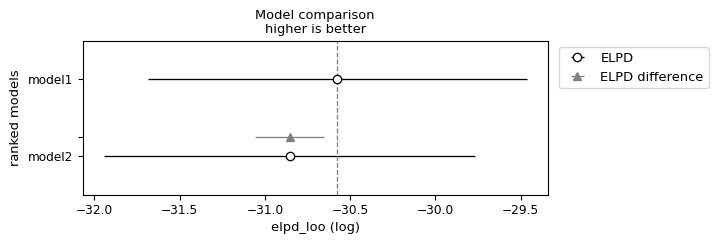

In [31]:
az.plot_compare(df_comp_loo, insample_dev=False)

/opt/conda/envs/pymc-dev/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/conda/envs/pymc-dev/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


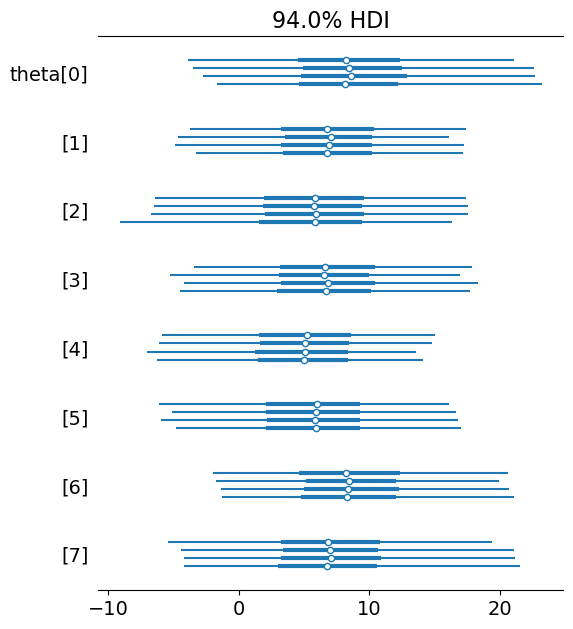

In [19]:
az.plot_forest(trace_h, var_names="theta")

/opt/conda/envs/pymc-test/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
/opt/conda/envs/pymc-test/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

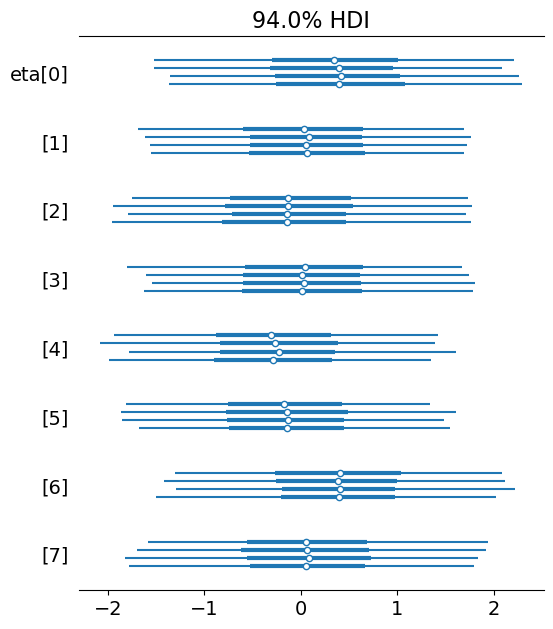

In [32]:
az.plot_forest(trace_h, var_names="eta")

In [40]:
trace_h

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [48]:
df_eta = az.InferenceData.to_dataframe(trace_h,groups='posterior',var_names='eta')

In [60]:
df_eta.columns

Index([      'chain',        'draw', ('eta[0]', 0), ('eta[1]', 1),
       ('eta[2]', 2), ('eta[3]', 3), ('eta[4]', 4), ('eta[5]', 5),
       ('eta[6]', 6), ('eta[7]', 7)],
      dtype='object')

array([[<Axes: title={'center': 'eta\n0'}>,
        <Axes: title={'center': 'eta\n1'}>,
        <Axes: title={'center': 'eta\n2'}>,
        <Axes: title={'center': 'eta\n3'}>],
       [<Axes: title={'center': 'eta\n4'}>,
        <Axes: title={'center': 'eta\n5'}>,
        <Axes: title={'center': 'eta\n6'}>,
        <Axes: title={'center': 'eta\n7'}>]], dtype=object)

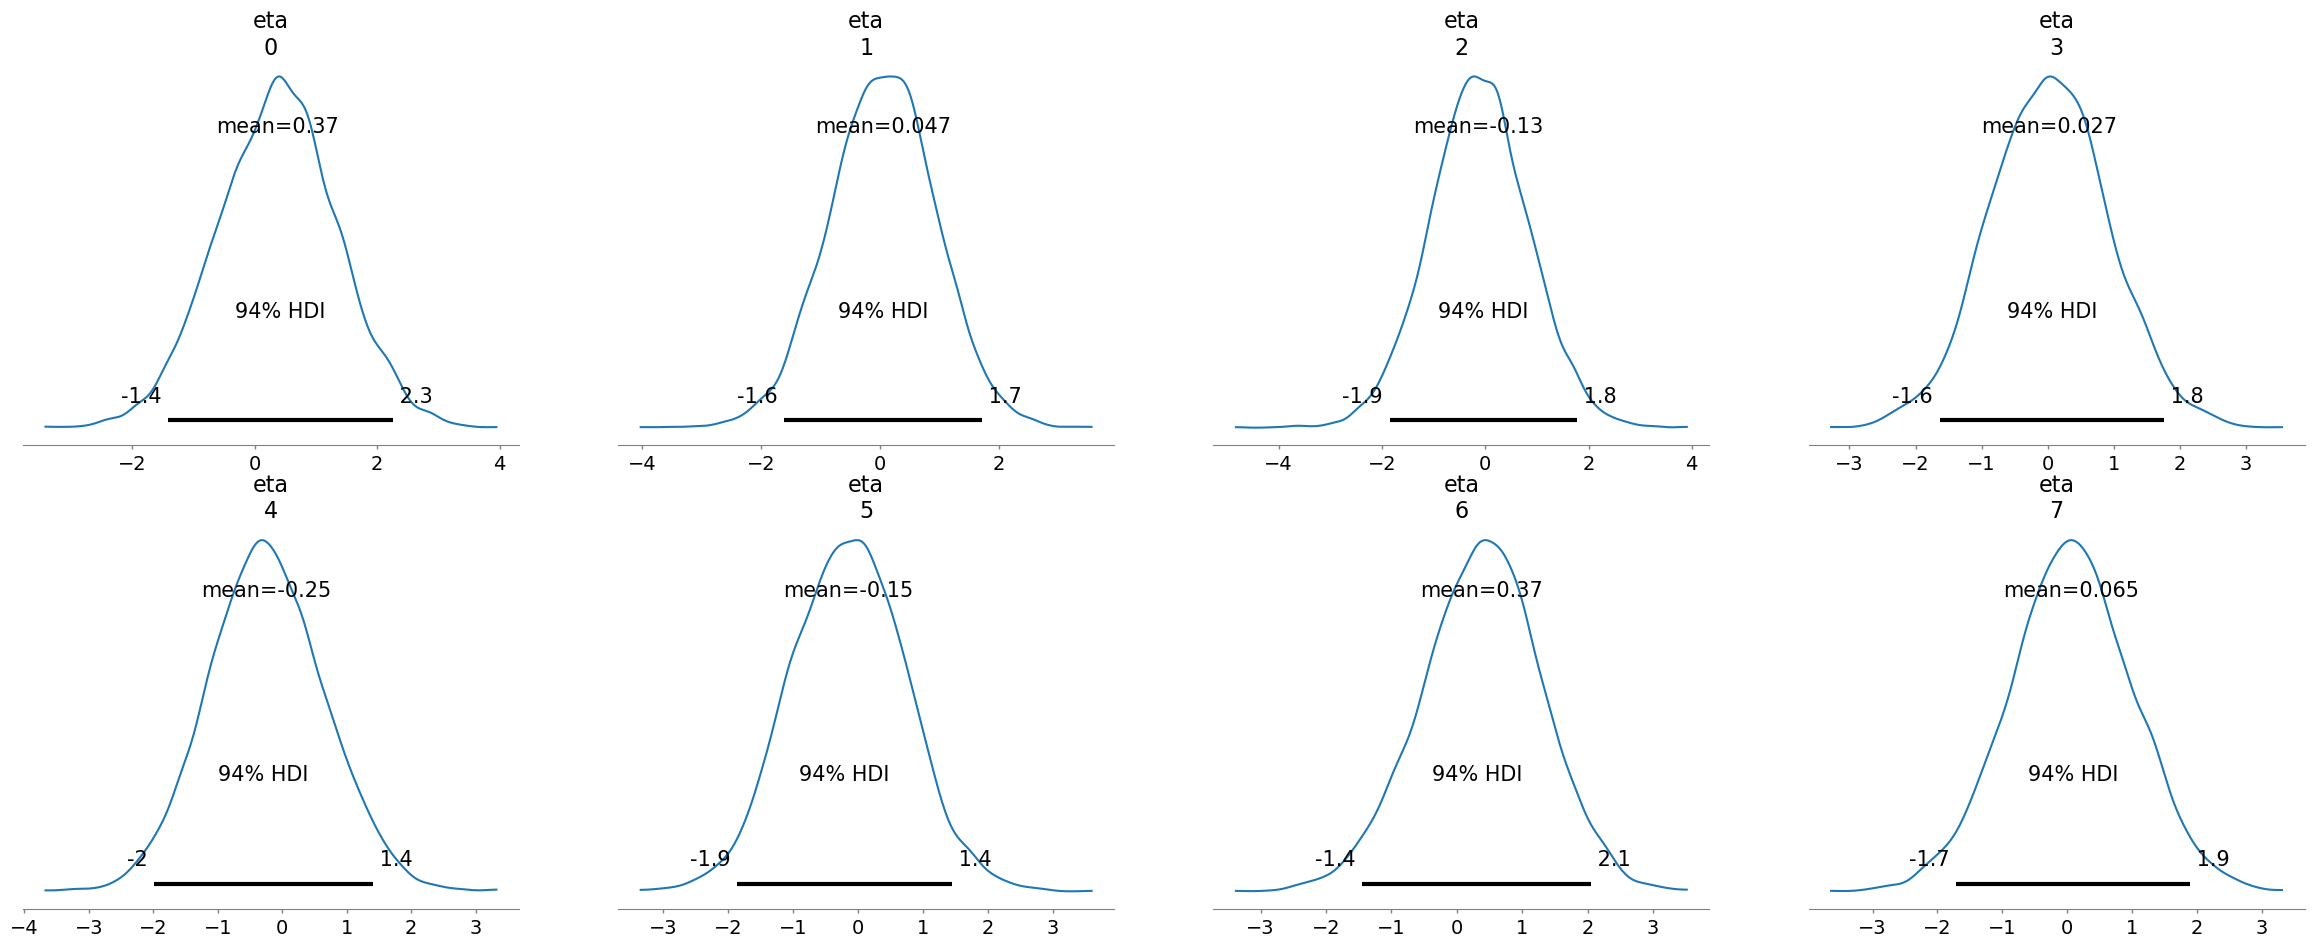

In [80]:
az.plot_posterior(trace_h, var_names=['eta'])

<Axes: title={'center': 'tau'}>

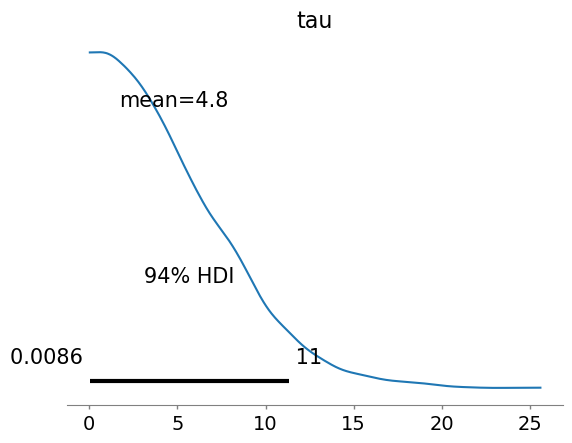

In [81]:
az.plot_posterior(trace_h, var_names=['tau'])